## Magnetic Tile Surface Defect Detection and Classification

In [1]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission

**Team:**
Ashwath Ramesh
Satoshi Taniguchi

**Course:** 
DAAN 570– Deep Learning (Spring I, 2021)

### Problem Statement
In this project, we have tried to detect surface defects and classify defects in a data set of magnetic tiles containing image defects. We have improved the classification accuracy by parallelizing feature extraction from raw images by CNN and feature extraction based on GT images by semantic segmentation.　In addition, we have confirmed that the use of augmentation improves classification accuracy.
    
    
* **Keywords:** Surface defect detection, Classification, Semantic segmentation, U-Net, CNN
	

### Data Collection
* Source(url):https://www.kaggle.com/alex000kim/magnetic-tile-surface-defects
* Short Description : This data set was collected at the magnetic tile factories in Zhejiang Province, China.
* Acknowledgements:
Huang, Y., Qiu, C., Guo, Y., Wang, X., & Yuan, K. (2018). Surface Defect Saliency of Magnetic Tile. 2018 IEEE 14th International Conference on Automation Science and Engineering (CASE). doi:10.1109/coase.2018.8560423
* Keywords: House price, room, zip code

### Required packages

* Add instructions to install the required packages


In [2]:
## In addition to the major packages such as TensorFlow, Panda, numpy, PIL, etc., the following package need to be installed
#pip install imgaug

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions


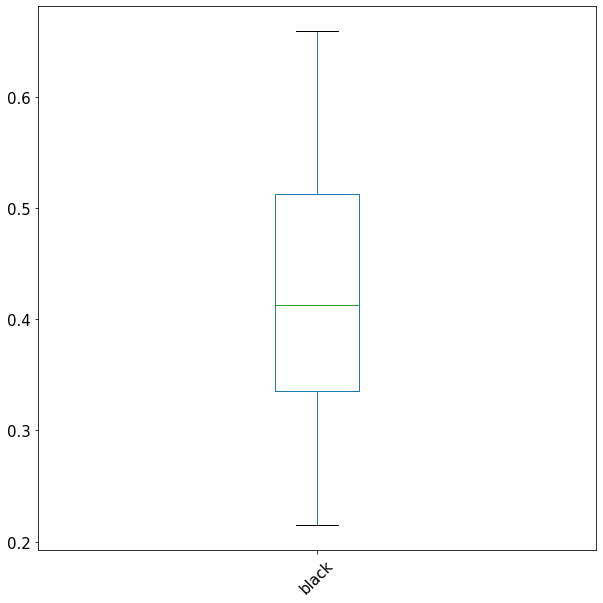

outliers are the follwing
0 images will be removed.


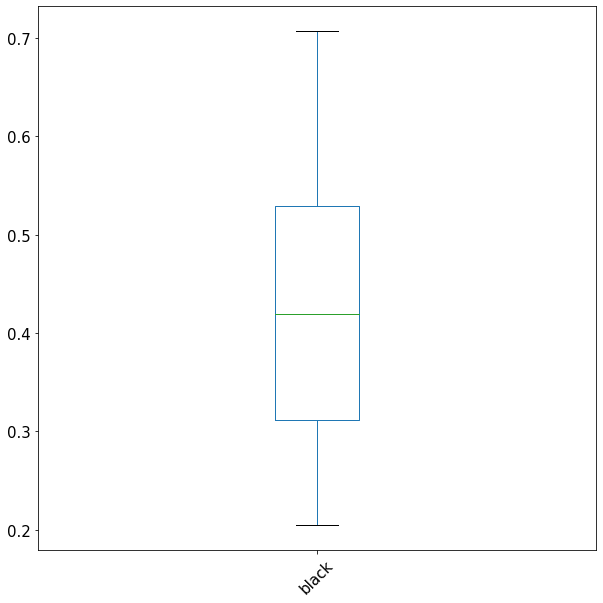

outliers are the follwing
0 images will be removed.


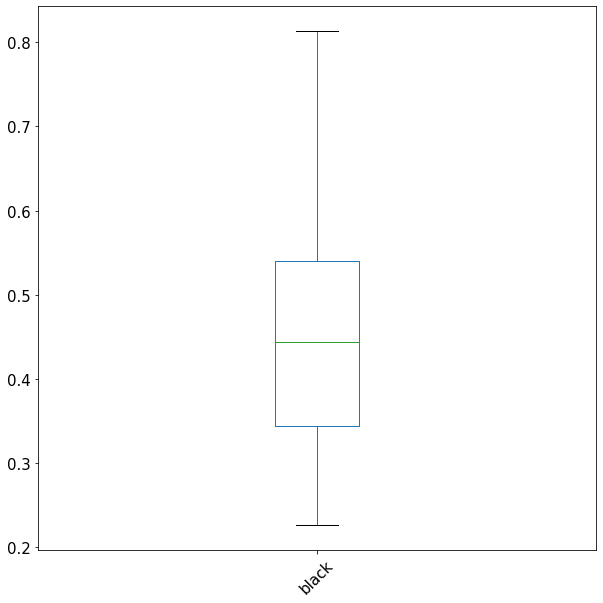

outliers are the follwing
0 images will be removed.


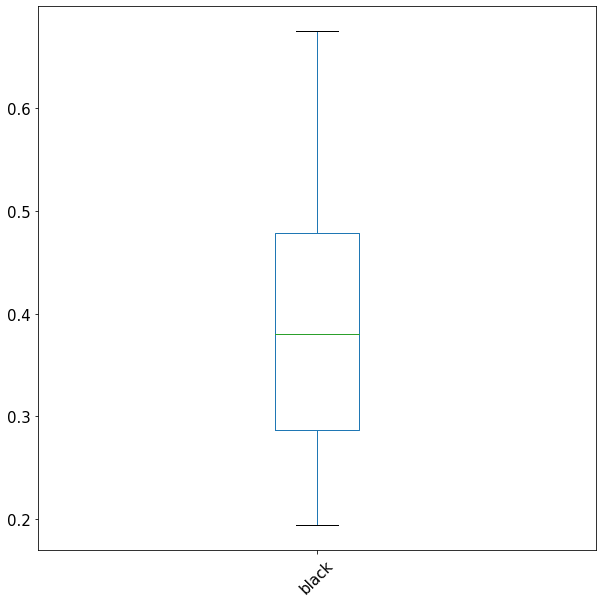

outliers are the follwing
0 images will be removed.


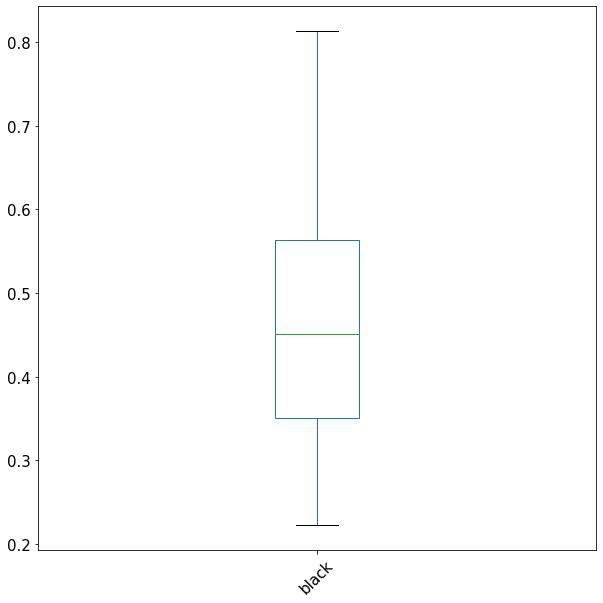

outliers are the follwing
0 images will be removed.


In [3]:
## This code of data preprocessing is for semantic segmentation
from glob import glob
import numpy as np
from os.path import join

##define directories
dr_crack = "./detection/MT_Crack/Imgs/"
dr_blowhole = "./detection/MT_Blowhole/Imgs/"
dr_break = "./detection/MT_Break/Imgs/"
dr_fray = "./detection/MT_Fray/Imgs/"
dr_uneven = "./detection/MT_Uneven/Imgs/"
dr_free = "./detection/MT_Free/Imgs/"

## load file list
file_crack = np.array(glob(join(dr_crack,'*.jpg')))
file_blowhole = np.array(glob(join(dr_blowhole,'*.jpg')))
file_break = np.array(glob(join(dr_break,'*.jpg')))
file_fray = np.array(glob(join(dr_fray,'*.jpg')))
file_uneven = np.array(glob(join(dr_uneven,'*.jpg')))
file_free = np.array(glob(join(dr_free,'*.jpg')))
file_crack_mask = np.array(glob(join(dr_crack,'*.png')))
file_blowhole_mask = np.array(glob(join(dr_blowhole,'*.png')))
file_break_mask = np.array(glob(join(dr_break,'*.png')))
file_fray_mask = np.array(glob(join(dr_fray,'*.png')))
file_uneven_mask = np.array(glob(join(dr_uneven,'*.png')))
file_free_mask = np.array(glob(join(dr_free,'*.png')))

## difine parameters 
img_size = 128
train_rate = 0.8
color_palette = [[0,0,0], [128, 0, 0],[0, 128, 0],[128, 128, 0],[0, 0, 128],[128, 0, 128]]
counter_train = 0
counter_test = 0
counter_train_mask = 0
counter_test_mask = 0

import pandas as pd
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt

## detect outliers based on value in each pixel.
def outlier_detector(file1):
    list1 = []
    for imgfile in file1:
        img = Image.open(imgfile)
        result =img
        result =result.resize((img_size,img_size))
        arr_img = np.array(result)
        list1.append(arr_img)
    arr= np.array(list1)
    arr = arr.astype(np.uint8)
    arr = arr /255 
    mean_value = np.mean(arr,axis=(1,2))
    df_mean = pd.DataFrame({'black': mean_value})
    
    ##boxplot
    boxplot = df_mean.boxplot(grid = False, rot = 45, fontsize = 15, figsize = (10,10))
    boxplot.plot()
    plt.show()
    
    ##detect outliers
    print('outliers are the follwing')
    col_names= ['black']
    all_outliers=np.array([])
    Q1 = df_mean['black'].quantile(0.25)
    Q3 = df_mean['black'].quantile(0.75)
    IQR = Q3 - Q1
    upper_b = Q3 + 1.5*IQR
    lower_b = Q1 - 1.5*IQR
    outliers = df_mean.index[ (df_mean['black'] < lower_b) | (df_mean['black'] > upper_b)]
    arr_outliers = np.array(outliers)
    all_outliers = np.concatenate([all_outliers, arr_outliers])
    all_outliers = np.unique(all_outliers)
    counter=1
    for imgs in arr_outliers:
        plt.subplot(2,2,counter)
        plt.imshow(arr[imgs], cmap=plt.get_cmap('gray'))
        counter = counter+1
    plt.show()
    all_outliers = np.array(all_outliers, dtype='int64')
    arr_cleaned = np.delete(arr, all_outliers,axis=0)
    print(str(len(file1)-len(arr_cleaned))+' images will be removed.' )
    return all_outliers

## apply outlier detector
outliers_crack = outlier_detector(file_crack)
outliers_blowhole = outlier_detector(file_blowhole)
outliers_break = outlier_detector(file_break)
outliers_fray = outlier_detector(file_fray)
outliers_uneven = outlier_detector(file_uneven)
## there is no outlier in cracks, blowhole, breaks, frays, unevens.


import imgaug.augmenters as iaa

## Add augmentation, 180 degree rotation and Gaussian Blur fileter.

aug_rot = iaa.Sequential([
    iaa.Affine(rotate=180)
], random_order=False)

aug_GauBlur = iaa.Sequential([
    iaa.GaussianBlur((0, 1.0) )
], random_order=False)

import os


## load image, apply augmentation, split dataset to train and test, save to directory.

def prepare_images_segmentation(file1):
    list1 = []
    ## load image
    for imgfile in file1:
        img = Image.open(imgfile)
        width, height = img.size
        result =img.resize((img_size,img_size))
        arr_img = np.array(result)
        list1.append(arr_img)
    arr= np.array(list1)
    arr = arr.astype(np.uint8)
    arr = arr.reshape(-1,img_size, img_size, 1)
    arr = np.repeat(arr, 3, axis=3)
    num = len(arr)
    p = np.random.RandomState(seed=1).permutation(len(arr)) ## sort randamly
    arr = arr[p]
    
    ## split dataset
    ## apply augmentation for only train data
    train = arr[0:int(train_rate*num)]
    train_rot = aug_rot(images =train)
    train_GauBlur = aug_GauBlur(images =train)

    test = arr[int(train_rate*num):num]

    
    global counter_train
    counter1 = counter_train
    counter1_rot = counter_train
    counter1_GauBlur = counter_train

    ## save data to directory
    for i in train:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/image/", str(counter1) + '.jpg'))
        counter1 +=1
    for i in train_rot:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/image/", str(counter1_rot) + 'rot.jpg'))
        counter1_rot +=1
    for i in train_GauBlur:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/image/", str(counter1_GauBlur) + 'GauBlur.jpg'))
        counter1_GauBlur +=1
 
    global counter_test
    counter2 = counter_test

    for i in test:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/test/image/", str(counter2) + '.jpg'))
        counter2 +=1

    counter_train = counter1
    counter_test =counter2
    
## prepare images for all types of defects
prepare_images_segmentation(file_crack)
prepare_images_segmentation(file_blowhole)
prepare_images_segmentation(file_break)
prepare_images_segmentation(file_fray)
prepare_images_segmentation(file_uneven)

## load mask, convert GT images to color masks, duplicate masks corresponding to augmentation,
## split dataset to train and test, save to directory.

def prepare_masks_segmentation(file,color):
    list1 = []
    ## load mask
    for imgfile in file:
        img = Image.open(imgfile)
        width, height = img.size
        result =img.resize((img_size,img_size))
        arr_img = np.array(result)
        arr_img = np.where(arr_img<1,0,255)
        list1.append(arr_img)
        arr= np.array(list1)
        
    arr = arr.astype(np.uint8)
    arr = arr.reshape(-1,img_size, img_size, 1)
    arr = np.repeat(arr, 3, axis=3)
    
    counter=0
    
    ##convert GT images to color masks
    for i in arr:
        arr[counter] = arr[counter]/255 * color
        counter +=1

    num = len(arr)
    p = np.random.RandomState(seed=1).permutation(len(arr)) ## sort randamly
    arr = arr[p]
    
    ## split dataset
    train = arr[0:int(train_rate*num)]
    test = arr[int(train_rate*num):num]
    train_rot = aug_rot(images =train)
    
    
    global counter_train_mask
    counter1 = counter_train_mask
    counter1_rot = counter_train_mask
    counter1_GauBlur = counter_train_mask

    
    for i in train:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/mask/", str(counter1) + '.png'))
        counter1 +=1
    for i in train_rot: ## duplicate masks corresponding to augmentation
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/mask/", str(counter1_rot) + 'rot.png'))
        counter1_rot +=1
    for i in train: ## duplicate masks corresponding to augmentation
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/train/mask/", str(counter1_GauBlur) + 'GauBlur.png'))
        counter1_GauBlur +=1


    global counter_test_mask
    counter2 = counter_test_mask

    for i in test:
        pil_img_gray = Image.fromarray(i)
        pil_img_gray.save(os.path.join("./detection/test/mask/", str(counter2) + '.png'))
        counter2 +=1
        
    counter_train_mask = counter1
    counter_test_mask =counter2
    
## prepare masks for all types of defects
prepare_masks_segmentation(file_crack_mask,color_palette[1])
prepare_masks_segmentation(file_blowhole_mask,color_palette[2])
prepare_masks_segmentation(file_break_mask,color_palette[3])
prepare_masks_segmentation(file_fray_mask,color_palette[4])
prepare_masks_segmentation(file_uneven_mask,color_palette[5])

## difine data set directories.
dataset_path_train = "./detection/train/"
dataset_path_test = "./detection/test/"


## normalize images
## create one-hot encoded lavels

def adjustData(img, mask):

    if np.max(img) > 1:
        img = img / 255. ## normalize images
    
    onehot = np.zeros((mask.shape[0], img_size, img_size, 6), dtype=np.uint8)
    for i in range(6):
        color = color_palette[i]

        temp = np.where((mask[:, :, :, 0] == color[0]) &
                        (mask[:, :, :, 1] == color[1]) &
                        (mask[:, :, :, 2] == color[2]), 1, 0)
        
        onehot[:, :, :, i] = temp  ## one-hot encoding

    return img, onehot


## define image and mask generator with vertical flip and holizontal flip
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

def trainGenerator(image_folder, batch_size=20, save_to_dir=[None, None]):

    data_gen_args = dict(
        horizontal_flip=True, ## horizontal flip augmentation
        vertical_flip=True, ## vertical flip augmentation
        rescale=None           
    )
    seed = 1                  


    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

## image generator
    image_generator = image_datagen.flow_from_directory(
        directory=image_folder,
        classes=['image'],      
        class_mode=None,        
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=seed,
        save_to_dir=save_to_dir[0]
    )

## mask generator
    mask_generator = mask_datagen.flow_from_directory(
        directory=image_folder,
        classes=['mask'],
        class_mode=None,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=seed,
        save_to_dir=save_to_dir[1]
    )

    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = adjustData(img, mask)
        yield img, mask

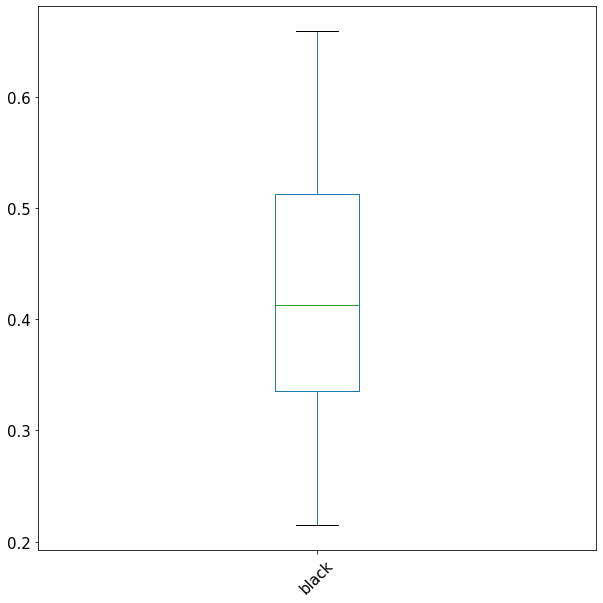

outliers are the follwing
0 images will be removed.


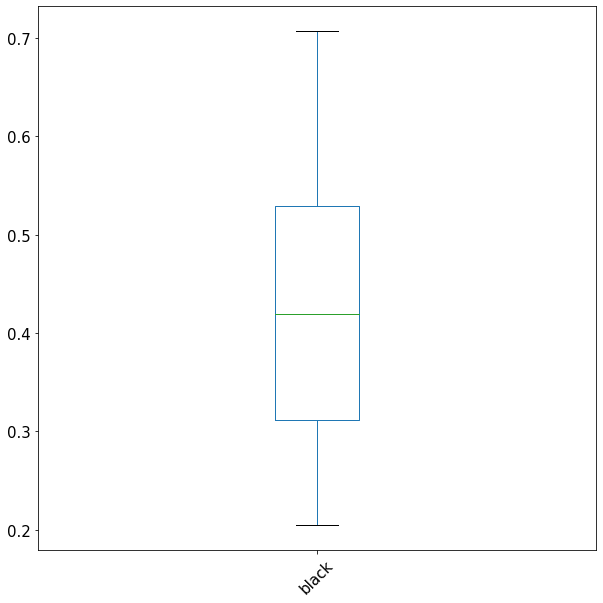

outliers are the follwing
0 images will be removed.


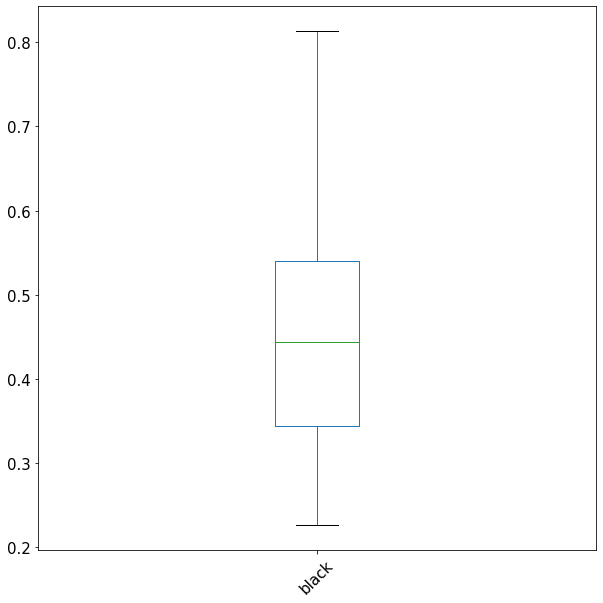

outliers are the follwing
0 images will be removed.


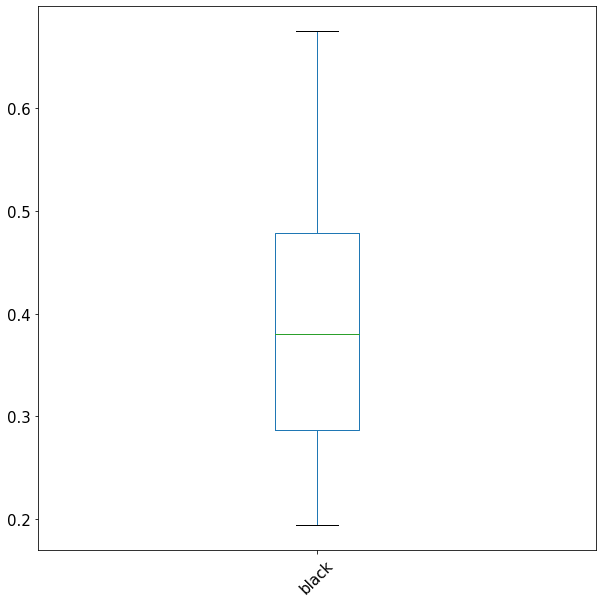

outliers are the follwing
0 images will be removed.


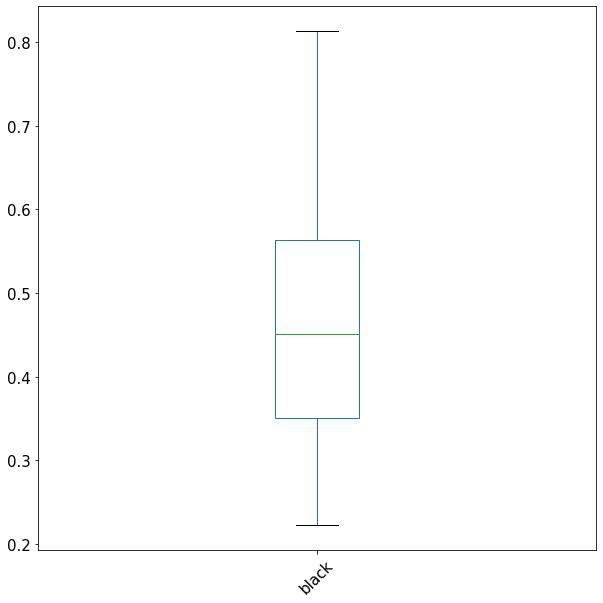

outliers are the follwing
0 images will be removed.


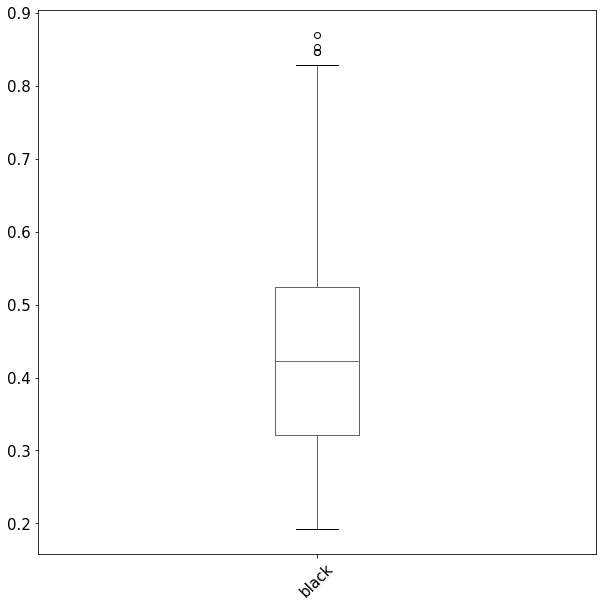

outliers are the follwing


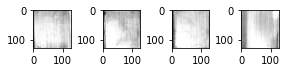

4 images will be removed.


In [4]:
## This code of data preprocessing is for classification
from glob import glob
import numpy as np
from os.path import join

##define directories
dr_crack = "./detection/MT_Crack/Imgs/"
dr_blowhole = "./detection/MT_Blowhole/Imgs/"
dr_break = "./detection/MT_Break/Imgs/"
dr_fray = "./detection/MT_Fray/Imgs/"
dr_uneven = "./detection/MT_Uneven/Imgs/"
dr_free = "./detection/MT_Free/Imgs/"

## load file list
file_crack = np.array(glob(join(dr_crack,'*.jpg')))
file_blowhole = np.array(glob(join(dr_blowhole,'*.jpg')))
file_break = np.array(glob(join(dr_break,'*.jpg')))
file_fray = np.array(glob(join(dr_fray,'*.jpg')))
file_uneven = np.array(glob(join(dr_uneven,'*.jpg')))
file_free = np.array(glob(join(dr_free,'*.jpg')))

## difine parameters 
img_size = 128
train_rate = 0.8
color_palette = [[0,0,0], [128, 0, 0],[0, 128, 0],[128, 128, 0],[0, 0, 128],[128, 0, 128]]
counter_train = 0
counter_test = 0
counter_train_mask = 0
counter_test_mask = 0

import pandas as pd
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt

## detect outliers based on value in each pixel.

def outlier_detector(file1):
    list1 = []
    for imgfile in file1:
        img = Image.open(imgfile)
        result =img
        result =result.resize((img_size,img_size))
        arr_img = np.array(result)
        list1.append(arr_img)
    arr= np.array(list1)
    arr = arr.astype(np.uint8)
    arr = arr /255 
    mean_value = np.mean(arr,axis=(1,2))
    df_mean = pd.DataFrame({'black': mean_value})
    
    ##boxplot
    boxplot = df_mean.boxplot(grid = False, rot = 45, fontsize = 15, figsize = (10,10))
    boxplot.plot()
    plt.show()
    
    ##detect outliers
    print('outliers are the follwing')
    col_names= ['black']
    all_outliers=np.array([])
    Q1 = df_mean['black'].quantile(0.25)
    Q3 = df_mean['black'].quantile(0.75)
    IQR = Q3 - Q1
    upper_b = Q3 + 1.5*IQR
    lower_b = Q1 - 1.5*IQR
    outliers = df_mean.index[ (df_mean['black'] < lower_b) | (df_mean['black'] > upper_b)]
    arr_outliers = np.array(outliers)
    all_outliers = np.concatenate([all_outliers, arr_outliers])
    all_outliers = np.unique(all_outliers)
    counter=1
    for imgs in arr_outliers:
        plt.subplot(5,5,counter)
        plt.imshow(arr[imgs], cmap=plt.get_cmap('gray'))
        counter = counter+1
    plt.show()
    all_outliers = np.array(all_outliers, dtype='int64')
    arr_cleaned = np.delete(arr, all_outliers,axis=0)
    print(str(len(file1)-len(arr_cleaned))+' images will be removed.' )
    return all_outliers

## apply outlier detector
outliers_crack = outlier_detector(file_crack)
outliers_blowhole = outlier_detector(file_blowhole)
outliers_break = outlier_detector(file_break)
outliers_fray = outlier_detector(file_fray)
outliers_uneven = outlier_detector(file_uneven)
outliers_free = outlier_detector(file_free)

import imgaug.augmenters as iaa

## Add augmentation, 180 degree rotation and Gaussian Blur fileter, vertical flip and horizontal flip

aug_rot = iaa.Sequential([
    iaa.Affine(rotate=180)
], random_order=False)

aug_GauBlur = iaa.Sequential([
    iaa.GaussianBlur((0, 1.0) )
], random_order=False)

aug_v_flip = iaa.Flipud()
aug_h_flip = iaa.Fliplr()

## load image, remove outliers, delete the 115th image and onwards, apply augmentation, split dataset to train and test
def prepare_images(file1,outliers):
    list1 = []
    for imgfile in file1:
        img = Image.open(imgfile)
        result =img
        result =result.resize((img_size,img_size))
        arr_img = np.array(result)
        list1.append(arr_img)
    arr= np.array(list1)
    arr = arr.astype(np.uint8)
    arr = np.delete(arr, outliers,axis=0) ## remove outliers
    arr = arr[0:115] ## delete the 115th image and onwards
    arr = arr.reshape(-1,img_size, img_size, 1)
    arr = np.repeat(arr, 3, axis=3)
    
    
    num = len(arr)
    train = arr[0:int(train_rate*num)]
    train_rot = aug_rot(images =train) 
    train_GauBlur = aug_GauBlur(images =train)
    train_v_flip = aug_v_flip(images =train)
    train_h_flip = aug_h_flip(images =train)
    train =np.concatenate([train,train_rot,train_GauBlur,train_v_flip,train_h_flip],0)
    test = arr[int(train_rate*num):num]
    num_train=len(train)
    num_test=len(test)
    return train, test, num_train, num_test

##devide train and test images for each category
crack_train, crack_test, num_crack_train, num_crack_test = prepare_images(file_crack,outliers_crack) 
blowhole_train, blowhole_test, num_blowhole_train, num_blowhole_test = prepare_images(file_blowhole,outliers_blowhole)
break_train, break_test, num_break_train, num_break_test = prepare_images(file_break,outliers_break)
fray_train, fray_test, num_fray_train, num_fray_test = prepare_images(file_fray,outliers_fray)
uneven_train, uneven_test, num_uneven_train, num_uneven_test = prepare_images(file_uneven,outliers_uneven)
free_train, free_test, num_free_train, num_free_test = prepare_images(file_free,outliers_free)

##concatenate images of each category to entire detasets
train_x= np.concatenate([crack_train,blowhole_train,break_train,fray_train,uneven_train,free_train],0)
test_x= np.concatenate([crack_test,blowhole_test,break_test,fray_test,uneven_test,free_test],0)
train_y = np.array([1]*num_crack_train + [2]*num_blowhole_train +[3]*num_break_train + [4]*num_fray_train + [5]*num_uneven_train +[0]*num_free_train)
test_y = np.array([1]*num_crack_test + [2]*num_blowhole_test +[3]*num_break_test+[4]*num_fray_test + [5]*num_uneven_test +[0]*num_free_test)

from tensorflow.keras.utils import to_categorical

np.random.seed(1) ## define seed as 1

##shuffle the order of images
p = np.random.permutation(len(train_x))
train_x = train_x[p]
train_y = train_y[p]
p = np.random.permutation(len(test_x))
test_x = test_x[p]
test_y = test_y[p]

##make y categorical
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

### Methodology of our segmentation model

1. Explan your Deep Learning process / methodology



2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Description 
 
 * Model 2
    * Description
 
 * Ensemble method
     * Description 
 
 
3. Add keywords  
**Keywords:** natural language processing, sentiment analysis, clustering, binary classification, multi-label classification, prediction
	___
 **Example**
* ConvNet
    * A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia). 
 
* **Keywords:** supervised learning, classification, ...

Explan your Deep Learning process / methodology

Model1
This model performs semantic segmentation, using U-Net for setmentation, and training on the image after the augmentation.

Keywords: Surface defect detection, Classification, Semantic segmentation, U-Net, CNN, Augmentation

In [7]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras import regularizers
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam

## define input_size
input_size = (img_size, img_size, 3)

## define Conv2D
def create_conv(input, filters, l2_reg, name):
    x = Conv2D(filters=filters,
               kernel_size=3,               
               activation='relu',           
               padding='same',              
               kernel_regularizer=regularizers.l2(l2_reg),
               name=name)(input)
    x = BatchNormalization()(x)
    return x

## define Conv2D transpose
def create_trans(input, filters, l2_reg, name):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=2,      
                        strides=2,         
                        activation='relu',  
                        padding='same',     
                        kernel_regularizer=regularizers.l2(l2_reg),
                        name=name)(input)
    x = BatchNormalization()(x)
    return x

## define U-Net
def unet():
    l2_reg = 0.0001

    input = Input((img_size, img_size, 3))

    conv1_1 = create_conv(input, filters=64, l2_reg=l2_reg, name='conv1c_1')
    conv1_2 = create_conv(conv1_1, filters=64, l2_reg=l2_reg, name='conv1c_2')
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool1')(conv1_2)

    conv2_1 = create_conv(pool1, filters=128, l2_reg=l2_reg, name='conv2c_1')
    conv2_2 = create_conv(conv2_1, filters=128, l2_reg=l2_reg, name='conv2c_2')
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool2')(conv2_2)

    conv3_1 = create_conv(pool2, filters=256, l2_reg=l2_reg, name='conv3c_1')
    conv3_2 = create_conv(conv3_1, filters=256, l2_reg=l2_reg, name='conv3c_2')
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool3')(conv3_2)

    conv4_1 = create_conv(pool3, filters=512, l2_reg=l2_reg, name='conv4c_1')
    conv4_2 = create_conv(conv4_1, filters=512, l2_reg=l2_reg, name='conv4c_2')
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool4')(conv4_2)

    conv5_1 = create_conv(pool4, filters=1024, l2_reg=l2_reg, name='conv5m_1')
    conv5_2 = create_conv(conv5_1, filters=1024, l2_reg=l2_reg, name='conv5m_2')
    trans1 = create_trans(conv5_2, filters=512, l2_reg=l2_reg, name='trans1')
    concat1 = Concatenate(name='concat1')([trans1, conv4_2])

    conv6_1 = create_conv(concat1, filters=512, l2_reg=l2_reg, name='conv6e_1')
    conv6_2 = create_conv(conv6_1, filters=512, l2_reg=l2_reg, name='conv6e_2')
    trans2 = create_trans(conv6_2, filters=256, l2_reg=l2_reg, name='trans2')
    concat2 = Concatenate(name='concat2')([trans2, conv3_2])

    conv7_1 = create_conv(concat2, filters=256, l2_reg=l2_reg, name='conv7e_1')
    conv7_2 = create_conv(conv7_1, filters=256, l2_reg=l2_reg, name='conv7e_2')
    trans3 = create_trans(conv7_2, filters=128, l2_reg=l2_reg, name='trans3')
    concat3 = Concatenate(name='concat3')([trans3, conv2_2])

    conv8_1 = create_conv(concat3, filters=128, l2_reg=l2_reg, name='conv8e_1')
    conv8_2 = create_conv(conv8_1, filters=128, l2_reg=l2_reg, name='conv8e_2')
    trans4 = create_trans(conv8_2, filters=64, l2_reg=l2_reg, name='trans4')
    concat4 = Concatenate(name='concat4')([trans4, conv1_2])

    conv9_1 = create_conv(concat4, filters=64, l2_reg=l2_reg, name='conv9e_1')
    conv9_2 = create_conv(conv9_1, filters=64, l2_reg=l2_reg, name='conv9e_2')

    output = Conv2D(filters=6,                   
                    kernel_size=1,                  
                    activation='softmax',           
                    name='output')(conv9_2)

    model = Model(input, output)
    model.compile(optimizer=Adam(lr=0.01),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])

    return model

model1 = unet()
model1.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1c_1 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 128, 128, 64) 256         conv1c_1[0][0]                   
__________________________________________________________________________________________________
conv1c_2 (Conv2D)               (None, 128, 128, 64) 36928       batch_normalization_22[0][0]     
_______________________________________________________________________________________

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [6]:
## define call back to save best weights.
from keras import callbacks

def callbacks_01(cp_dir):
    cp_path = cp_dir + '/' + 'best_segmentation_weights.h5'

    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath=cp_path,
            monitor='val_loss',
            save_best_only=True)]
    return callbacks_list

## compile our model with adam (lr = 0.0001)
model1.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])
callbacks_list = callbacks_01('./cp')


## define data genarators
train_gen = trainGenerator(dataset_path_train, batch_size=20)
validation_gen = trainGenerator(dataset_path_test, batch_size=20)


## train model.
history = model1.fit_generator(
    generator=train_gen,
    steps_per_epoch=5,
    callbacks=callbacks_list,
    epochs=1500,
    validation_data=validation_gen,
    validation_steps=10
)

## save accuracies and loss values
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('segmentation_history.csv')

<ipython-input-6-667cdac8e972>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(


Found 936 images belonging to 1 classes.
Found 936 images belonging to 1 classes.
Epoch 1/1500
5/5 [==============================] - ETA: 0s - loss: 2.9671 - accuracy: 0.2173Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
5/5 [==============================] - 24s 2s/step - loss: 2.9671 - accuracy: 0.2173 - val_loss: 2.4626 - val_accuracy: 0.4690
Epoch 2/1500
5/5 [==============================] - 7s 2s/step - loss: 2.8087 - accuracy: 0.2243 - val_loss: 2.4390 - val_accuracy: 0.7725
Epoch 3/1500
5/5 [==============================] - 7s 2s/step - loss: 2.7046 - accuracy: 0.2338 - val_loss: 2.4301 - val_accuracy: 0.6389
Epoch 4/1500
5/5 [==============================] - 7s 2s/step - loss: 2.6234 - accuracy: 0.2346 - val_loss: 2.4229 - val_accuracy: 0.3636
Epoch 5/1500
5/5 [==============================] - 7s 2s/step - loss: 2.5491 - accuracy: 0.2373 - val_loss: 2.4184 - val_accuracy: 0.2984
Epoch 6/1500
5/5 [==============================] - 7s 2s/step

### Methodology of our classification model

1. Explan your Deep Learning process / methodology



2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Description 
 
 * Model 2
    * Description
 
 * Ensemble method
     * Description 
 
 
3. Add keywords  
**Keywords:** natural language processing, sentiment analysis, clustering, binary classification, multi-label classification, prediction
	___
 **Example**
* ConvNet
    * A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia). 
 
* **Keywords:** supervised learning, classification, ...

Explan your Deep Learning process / methodology

Model2
This model is a classification model. It consists of two parallel modules: one for CNN feature extraction from raw images and the other for CNN feature extraction from segmentation results. In the end, the output of the two modules are combined and classified by FCN.

Keywords: Surface defect detection, Classification, Semantic segmentation, U-Net, CNN, Augmentation

In [5]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras import regularizers
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam

## define Conv2D
def create_conv(input, filters, l2_reg, name):
    x = Conv2D(filters=filters,
               kernel_size=3,               
               activation='relu',           
               padding='same',              
               kernel_regularizer=regularizers.l2(l2_reg),
               name=name)(input)
    x = BatchNormalization()(x)
    return x

## define Conv2D transpose
def create_trans(input, filters, l2_reg, name):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=2,      
                        strides=2,         
                        activation='relu',  
                        padding='same',     
                        kernel_regularizer=regularizers.l2(l2_reg),
                        name=name)(input)
    x = BatchNormalization()(x)
    return x


## define U-Net
l2_reg = 0.0001

input = Input((img_size, img_size, 3))

conv1_1 = create_conv(input, filters=64, l2_reg=l2_reg, name='conv1c_1')
conv1_2 = create_conv(conv1_1, filters=64, l2_reg=l2_reg, name='conv1c_2')
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool1')(conv1_2)

conv2_1 = create_conv(pool1, filters=128, l2_reg=l2_reg, name='conv2c_1')
conv2_2 = create_conv(conv2_1, filters=128, l2_reg=l2_reg, name='conv2c_2')
pool2 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool2')(conv2_2)

conv3_1 = create_conv(pool2, filters=256, l2_reg=l2_reg, name='conv3c_1')
conv3_2 = create_conv(conv3_1, filters=256, l2_reg=l2_reg, name='conv3c_2')
pool3 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool3')(conv3_2)

conv4_1 = create_conv(pool3, filters=512, l2_reg=l2_reg, name='conv4c_1')
conv4_2 = create_conv(conv4_1, filters=512, l2_reg=l2_reg, name='conv4c_2')
pool4 = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool4')(conv4_2)

conv5_1 = create_conv(pool4, filters=1024, l2_reg=l2_reg, name='conv5m_1')
conv5_2 = create_conv(conv5_1, filters=1024, l2_reg=l2_reg, name='conv5m_2')
trans1 = create_trans(conv5_2, filters=512, l2_reg=l2_reg, name='trans1')
concat1 = Concatenate(name='concat1')([trans1, conv4_2])

conv6_1 = create_conv(concat1, filters=512, l2_reg=l2_reg, name='conv6e_1')
conv6_2 = create_conv(conv6_1, filters=512, l2_reg=l2_reg, name='conv6e_2')
trans2 = create_trans(conv6_2, filters=256, l2_reg=l2_reg, name='trans2')
concat2 = Concatenate(name='concat2')([trans2, conv3_2])

conv7_1 = create_conv(concat2, filters=256, l2_reg=l2_reg, name='conv7e_1')
conv7_2 = create_conv(conv7_1, filters=256, l2_reg=l2_reg, name='conv7e_2')
trans3 = create_trans(conv7_2, filters=128, l2_reg=l2_reg, name='trans3')
concat3 = Concatenate(name='concat3')([trans3, conv2_2])

conv8_1 = create_conv(concat3, filters=128, l2_reg=l2_reg, name='conv8e_1')
conv8_2 = create_conv(conv8_1, filters=128, l2_reg=l2_reg, name='conv8e_2')
trans4 = create_trans(conv8_2, filters=64, l2_reg=l2_reg, name='trans4')
concat4 = Concatenate(name='concat4')([trans4, conv1_2])

conv9_1 = create_conv(concat4, filters=64, l2_reg=l2_reg, name='conv9e_1')
conv9_2 = create_conv(conv9_1, filters=64, l2_reg=l2_reg, name='conv9e_2')

output = Conv2D(filters=6,                   
                    kernel_size=1,                  
                    activation='softmax',           
                    name='output')(conv9_2)

unet = Model(input, output)


## load weights from a result of segmentation learning and convert the weights unlearnable
unet.load_weights('./cp/best_segmentation_weights.h5')
for i in range(54):
    unet.layers[i].trainable=False
    
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose

##define CNN-1
x = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer='he_uniform',
                padding='same', input_shape=(img_size, img_size, 6))(output)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x_concatenate1= Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
cnn_1=Model(inputs=input,outputs=x_concatenate1)

##define CNN-2
x = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer='he_uniform',
                padding='same', input_shape=(img_size, img_size, 3))(input)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x_concatenate2= Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
cnn_2=Model(inputs=input,outputs=x_concatenate2)

import tensorflow as tf
from tensorflow.keras.layers import *

##define FCN
combined = concatenate([x_concatenate1,x_concatenate2])
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(combined)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(6, activation='softmax', kernel_initializer='he_uniform')(x)
model2 = Model(inputs=input,outputs=x)

model2.summary()

## compile our model with adam (lr = 0.0001)
model2.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1c_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv1c_1[0][0]                   
__________________________________________________________________________________________________
conv1c_2 (Conv2D)               (None, 128, 128, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [ ]:
## define call back to save best weights.
from keras import callbacks

def callbacks_02(cp_dir):
    cp_path = cp_dir + '/' + 'best_classification_weights.h5'

    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath=cp_path,
            monitor='val_loss',
            save_best_only=True)]
    return callbacks_list

callbacks_list = callbacks_02('./cp')

## train model.
history = model2.fit(train_x, train_y, batch_size=256,
          epochs=100,
          callbacks=callbacks_list,
          validation_split=0.20,
          shuffle=True)

## save accuracies and loss values
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('classification_history.csv')

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

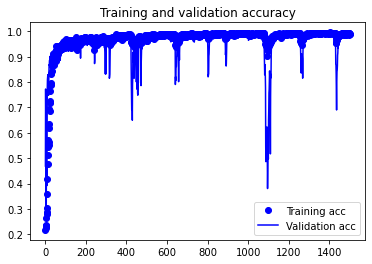

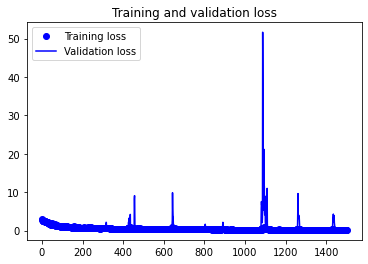

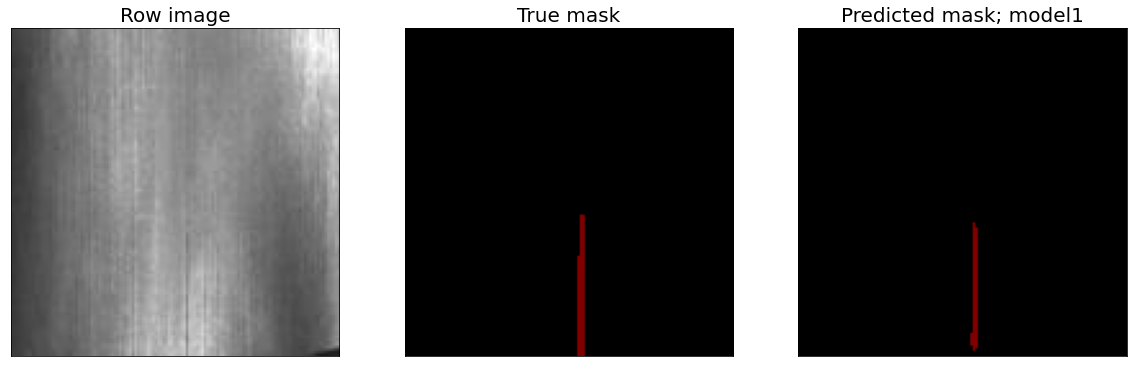

In [8]:
## this evaluation is for segmentation

##load best weights to the model1
model1.load_weights('./cp/best_segmentation_weights.h5')

## evaluation of accuracy

df1 = pd.read_csv('segmentation_history.csv')
acc = df1['accuracy']
val_acc = df1['val_accuracy']
loss = df1['loss']
val_loss = df1['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## define prediction masks. This function convert an input image to a color mask
def mask_prediction(arr_img):
    arr_img = arr_img[np.newaxis, ...]
    pred_y = model1.predict(arr_img)  ## predict result
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = np.array(pred_mask)
    pred_mask= pred_mask.astype(np.uint8)
    pred_mask = pred_mask.reshape(-1,img_size, img_size, 1)
    pred_mask = np.repeat(pred_mask, 3, axis=3)
    pred_mask = np.squeeze(pred_mask)
    defect_class = [0,1,2,3,4,5]
    pred_mask_x =pred_mask[:,:,0]
    pred_mask_y =pred_mask[:,:,1]
    pred_mask_z =pred_mask[:,:,2]

    for i in range(6):   ## convert a lavel to a color mask
        classification = defect_class[i]
        color = color_palette[i]

        pred_mask_x = np.where((pred_mask_x == classification), color[0], pred_mask_x)
        pred_mask_y = np.where((pred_mask_y == classification), color[1], pred_mask_y)
        pred_mask_z = np.where((pred_mask_z == classification), color[2], pred_mask_z)

    pred_mask_color = np.stack([pred_mask_x,pred_mask_y,pred_mask_z],2)
    return pred_mask_color

## show result of segmentation
file = './detection/test/image/0.jpg' ## select an image that you want to show
file_mask = file.replace('image','mask').replace('jpg','png')
img = Image.open(file)
img = np.array(img)/255
pred_m = mask_prediction(img)
fact_m = Image.open(file_mask)

img = np.squeeze(img)

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,20))

ax[0].imshow(img, cmap='Greys')
ax[1].imshow(fact_m, cmap='Greys')
ax[2].imshow(pred_m)
ax[0].set_title('Row image', fontsize=20)
ax[1].set_title('True mask', fontsize=20)
ax[2].set_title('Predicted mask; model1', fontsize=20)

for i in range(3):
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
plt.show()

The best validation accuracy was 98.5%. That is good enough to predict masks.
As a result, The model predicted good masks as shown in the figure.

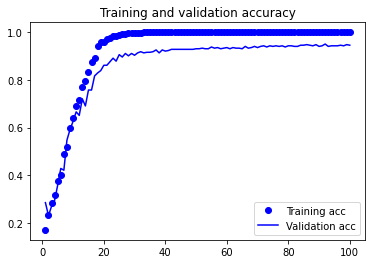

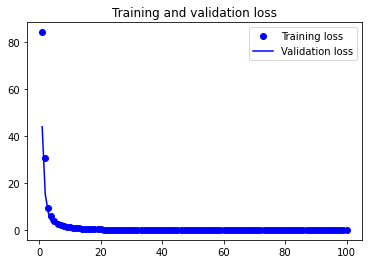

The result from model: [[2.2986124e-07 9.4939172e-01 4.3836419e-04 5.0067015e-02 4.7366971e-06
  9.7879456e-05]]
The model predicted this image as crack.
The answer: [0. 1. 0. 0. 0. 0.]
The answer is crack.


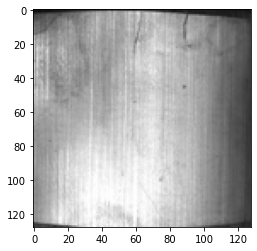

In [16]:
## This evaluation is for classification

##load best weights to the model2
model2.load_weights('./cp/best_classification_weights.h5')


## evaluation of accuracy
df1 = pd.read_csv('classification_history.csv')
acc = df1['accuracy']
val_acc = df1['val_accuracy']
loss = df1['loss']
val_loss = df1['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##show result from models for each unforeseen image.Chose the idx value.
idx = 6
img = test_x[idx]
img = (np.expand_dims(img,0))
predictions_single_model = model2.predict(img)
print('The result from model: ' +str(predictions_single_model))
print('The model predicted this image as crack.')
print('The answer: ' +str(test_y[idx]))
print('The answer is crack.')
plt.imshow(test_x[idx])
plt.show()

In [17]:
score = model2.evaluate(test_x, test_y, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

4/4 [==============================] - 7s 2s/step - loss: 0.9270 - accuracy: 0.8155
Test loss: 0.9270420074462891
Test accuracy: 0.8155339956283569


The prediction accuracy for the test data set was 82%.
As a result, The model can predict class of images as shown in the figure.

### Issues / Improvements
1. Our CNN modules are very simple. Therefore we can improve the prediction accuracy by using more complex CNN modeules.
2. The gap between the validation accuracy and the test accuracy was large.That was due to the bias of the original data set due to the order in which it was stored, and the possibility that the features of the test data set differed from those of the augmentation data set. Therefore, shuffling the datasets in the prior and changing the variation of the augmentation will be our future efforts.

###  References
Academic references
[1] Tian Wang, Yang Chen, Meina Qiao , Hichem Snoussi, A fast and robust convolutional neural network-based defect detection model in product quality control, The International Journal of Advanced Manufacturing Technology - A fast and robust convolutional neural network-based defect detection model in product quality control | SpringerLink 
[2] Yibin Huang, Congying Qiu, Yue Guo, Xiaonan Wang, Kui Yuan, Surface Defect Saliency of Magnetic Tile, the 14th IEEE International Conference on Automation and Engineering, 2018 - Surface defect saliency of magnetic tile | SpringerLink
[3] Ronneberger, O., Fischer, P., Brox, T.: U-Net: convolutional networks for biomedical image segmentation. In: Navab, N., Hornegger, J., Wells, W.M., Frangi, A.F. (eds.) MICCAI 2015. LNCS, vol. 9351, pp. 234–241. Springer, Heidelberg (2015).
[4] Magnetic Tile Surface Defects | Kaggle

Online references
[1] Magnetic Tile Surface Defects | Kaggle: https://www.kaggle.com/alex000kim/magnetic-tile-surface-defects
[2] Convolutional Neural Network with Keras: https://jaketae.github.io/study/cnn/
[3] Semantic Segmentation using U-Net on Pascal VOC 2012: https://github.com/tks10/segmentation_unet
	

### Credits
Our code for the Image generator and one-hot encoding is based on this web site.
https://github.com/tks10/segmentation_unet

The code for our CNN module is based on this site.
https://jaketae.github.io/study/cnn/

In [ ]:
# End of Project